In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math as math
import pandas as pd

In [ ]:
# Our SEIAVRD Model




r_county = .4 # % of 2020 trump votes
# parameter values
t_incubation = 2.8 #time from exposed to to infected
v_incubation = 10.17 #time from vaccinated to vaccine activation, weighted average of pfizer, moderna, johnson&johnson
r_time = 9 #average covid recovery time
N = 129205279.0 #initial population

# initial number of infected and recovered individual
i_initial = 9500000
e_initial = i_initial*t_incubation
a_initial = 0
v_initial = 0
r_initial = 0
d_initial = 0 #cumulative total dead
c_initial = 9500000 #cumulative total symptomatic to fit to data
s_initial = N - e_initial - i_initial - v_initial - r_initial


alpha = .92 # vaccine efficacy against infection, weighted average of pfizer, moderna, johnson&johnson
b = 0 # vaccination proportion by state/county
beta = 1/t_incubation # rate of emigration from exposed
gammai = 0.0000045/100000 # rate of susceptibles exposed by infected
gammaa = 0.8*gammai # rate of susceptibles exposed by asymptomatic
mu = .00189/3 # death rate from infection without effective vaccination
nu = .00982*2 # vaccination rate
lambdaa = 1/r_time # rate of asymptomatic to recovered
lambdai = 1/r_time # rate of infected to recovered
phi = 1/v_incubation # rate of vaccine activation
sigma = .35 # ratio of asymptomatic cases to all cases



if r_county < .25:
  b = .553

elif .25 <= r_county < .45:
  b = .531
elif .45 <= r_county < .55:
  b = .490
elif .55 <= r_county < .75:
  b = .422
else:
  b = .347


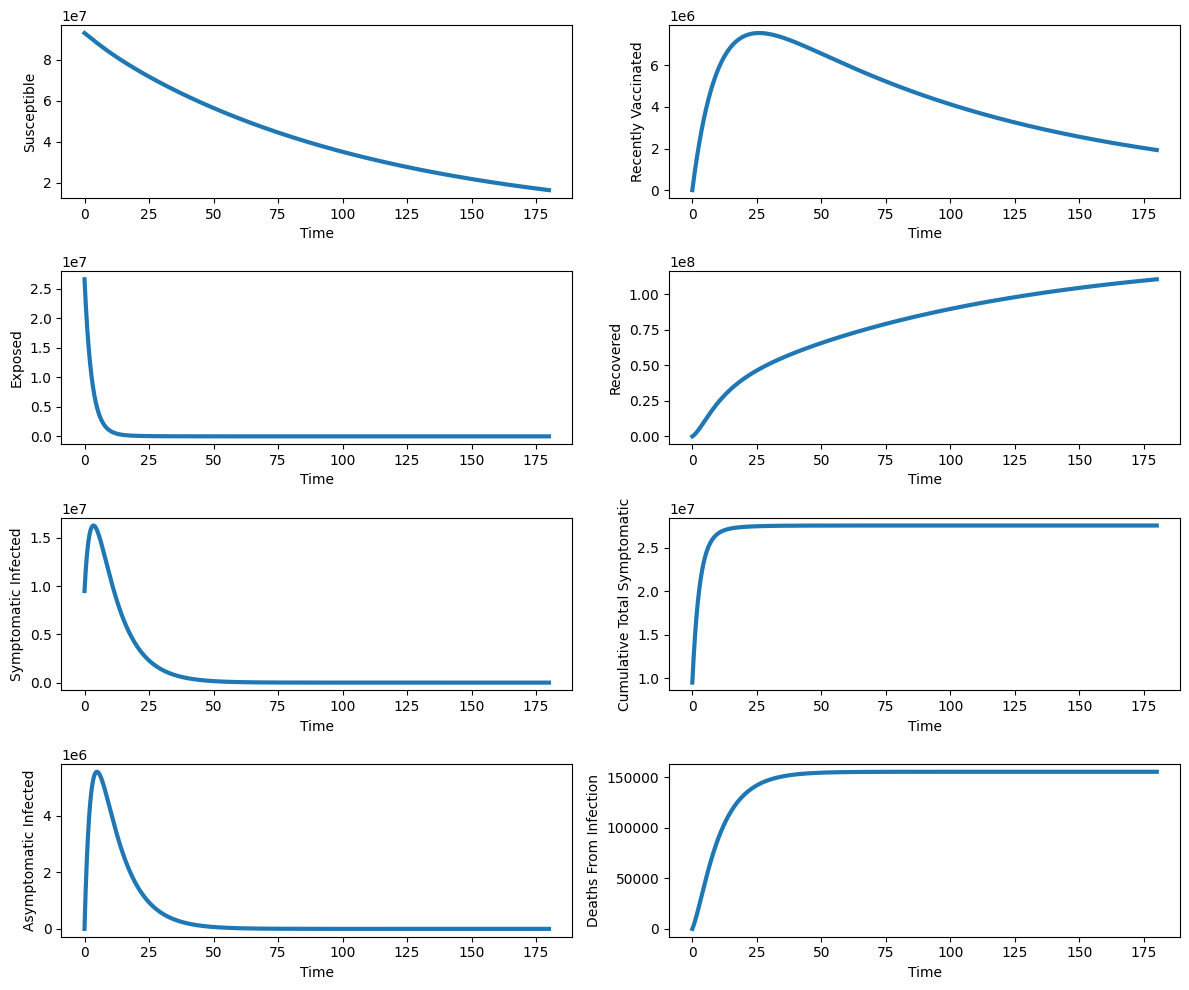

In [ ]:
# Our SEIAVR model constant death rate

def modelcd(x, t, alpha, b, beta, gammaa, gammai, lambdaa, lambdai, mu, nu, phi, sigma):
    s, e, i, a, v, r, d, c = x



    dsdt = -gammai*s*i-nu*b*s-gammaa*s*a+phi*(1-alpha)*v
    dedt = gammai*s*i-beta*e+gammaa*s*a
    didt = (1-sigma)*beta*e-mu*i-lambdai*i
    dadt = sigma*beta*e-lambdaa*a
    dvdt = nu*b*s-phi*(1-alpha)*v-phi*alpha*v
    drdt = lambdaa*a+lambdai*i+phi*alpha*v
    dddt = mu*i
    dcdt = (1-sigma)*beta*e
    return [dsdt, dedt, didt, dadt, dvdt, drdt, dddt, dcdt]

t = np.linspace(0, 180, 2000)
x_initial = s_initial, e_initial, i_initial, a_initial, v_initial, r_initial, d_initial, c_initial
soln = odeint(modelcd, x_initial, t, args=(alpha, b, beta, gammaa, gammai, lambdaa, lambdai, mu, nu, phi, sigma))
s, e, i, a, v, r, d, c = soln.T


def plotdata(t, s, e, i, a, v, r, d, c):
    # plot the data
    fig, ax=plt.subplots(4,2,figsize=(12,10))



    ax[0,0].plot(t, s, lw=3, label='Susceptible')
    ax[0,0].set_xlabel('Time');
    ax[0,0].set_ylabel('Susceptible');

    ax[1,0].plot(t, e, lw=3, label='Exposed')
    ax[1,0].set_xlabel('Time');
    ax[1,0].set_ylabel('Exposed');

    ax[2,0].plot(t, i, lw=3, label='Symptomatic Infected')
    ax[2,0].set_xlabel('Time');
    ax[2,0].set_ylabel('Symptomatic Infected');

    ax[3,0].plot(t, a, lw=3, label='Asymptomatic Infected')
    ax[3,0].set_xlabel('Time');
    ax[3,0].set_ylabel('Asymptomatic Infected');

    ax[0,1].plot(t, v, lw=3, label='Recently Vaccinated')
    ax[0,1].set_xlabel('Time');
    ax[0,1].set_ylabel('Recently Vaccinated');

    ax[1,1].plot(t, r, lw=3, label='Recovered')
    ax[1,1].set_xlabel('Time');
    ax[1,1].set_ylabel('Recovered');

    ax[2,1].plot(t, c, lw=3, label='Cumultative Total Symptomatic')
    ax[2,1].set_xlabel('Time');
    ax[2,1].set_ylabel('Cumulative Total Symptomatic');

    ax[3,1].plot(t, d, lw=3, label='Deaths From Infection')
    ax[3,1].set_xlabel('Time');
    ax[3,1].set_ylabel('Deaths From Infection');




    plt.tight_layout()

plotdata(t, s, e, i, a, v, r, d, c)

In [ ]:
R0 = (beta)*r_time
print(R0)

3.2142857142857144


In [ ]:
#Parameter Estimation
import pandas as pd

import scipy.optimize as optimize
from scipy.optimize import least_squares
from scipy.stats import poisson
from scipy.stats import norm

In [ ]:
qdf = pd.read_csv('/content/drive/Shareddrives/QRLSSP 2024/COVID/Python Code/us-counties-2021.csv')
qdf['county'] = qdf['county'].str.lower()
qdf['state'] = qdf['state'].str.lower()
qdf['county_state'] = qdf['county'] + '-' + qdf['state']
print("Total counties including Alaska and Hawaii after concatenating state & county US counites:", len(qdf['county_state'].unique()))
qdf['date'] = pd.to_datetime(qdf['date'], errors='coerce')

qdf = qdf.dropna(subset=['date'])

start_date = '2021-03-01'
end_date = '2021-09-01'

date_filtered_data = qdf[(qdf['date'] >= start_date) & (qdf['date'] <= end_date)]

vdf = pd.read_csv('/content/drive/Shareddrives/QRLSSP 2024/COVID/Python Code/2020 Election Voting by County csv.csv')
vdf = vdf[~vdf['state'].isin(['alaska', 'hawaii'])]
vdf['name'] = vdf['name'].str.lower()
vdf['state'] = vdf['state'].str.lower()
vdf['name_state'] = vdf['name'] + '-' + vdf['state']
vdf['trumpd_votes_ratio'] = vdf['results_trumpd'] / vdf['votes']
print("Total counties including Alaska and Hawaii after concatenating state & county Voting:", len(vdf['name_state'].unique()))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/Shareddrives/QRLSSP 2024/COVID/Python Code/us-counties-2021.csv'

In [ ]:
# Categorize counties into a1 to a5 based on Trump vote ratios
a1, a2, a3, a4, a5 = [], [], [], [], []

for _, row in vdf.iterrows():
    county = row['fips']
    ratio = row['trumpd_votes_ratio']
    if ratio <= 0.25:
        a1.append(county)
    elif 0.25 <= ratio < 0.45:
        a2.append(county)
    elif 0.45 <= ratio < 0.55:
        a3.append(county)
    elif 0.55 <= ratio < 0.75:
        a4.append(county)
    else:
        a5.append(county)

# Print counts of counties in each category
print("a1:", len(a1))
print("a2:", len(a2))
print("a3:", len(a3))
print("a4:", len(a4))
print("a5:", len(a5))
print("Total Counites:",len(a1)+len(a2)+len(a3)+len(a4)+len(a5))

In [ ]:
def aggregate_category_data(category, category_counties):
    # Filter COVID-19 data for counties in the category
    category_data = date_filtered_data[date_filtered_data['fips'].isin(category_counties)]

    # Group by date and aggregate cases and deaths
    category_aggregated = category_data.groupby('date').agg({'cases': 'sum', 'deaths': 'sum'}).reset_index()

    # Return the aggregated data
    return category_aggregated

# Aggregate data for each category
category_a1_data = aggregate_category_data('a1', a1)
category_a2_data = aggregate_category_data('a2', a2)
category_a3_data = aggregate_category_data('a3', a3)
category_a4_data = aggregate_category_data('a4', a4)
category_a5_data = aggregate_category_data('a5', a5)

# Now you can access the aggregated data for each category
print(category_a1_data.head())
print(category_a2_data.head())
print(category_a3_data.head())
print(category_a4_data.head())
print(category_a5_data.head())


In [ ]:
times = #time data points
data = #deaths data points

In [ ]:
def x0fcn(params, data):
	S0 = 1.0 - (data[0]/params[2])
	I0 = data[0]/params[2]
	R0 = 0.0
	X0 = [S0, I0, R0]

	return X0

In [ ]:
def yfcn(res, params):
	return res[:,1]*params[2]

In [ ]:
#Define our wrapper to run the exponential ode and return residuals
#####

def minifisher (times, params, data, delta = 0.001):
	#params = np.array(params)
	listX = []
	params_1 = np.array (params)
	params_2 = np.array (params)
	for i in range(len(params)):
		params_1[i] = params[i] * (1+delta)
		params_2[i]= params[i] * (1-delta)

		res_1 = odeint(modelcd.model, x0fcn(params_1,data), times, args=(params_1,))
		res_2 = odeint(modelcd.model, x0fcn(params_2,data), times, args=(params_2,))
		subX = (modelcd.yfcn(res_1, params_1) - modelcd.yfcn(res_2, params_2)) / (2 * delta * params[i])
		listX.append(subX.tolist())
	X = np.matrix(listX)
	FIM = np.dot(X, X.transpose())
	return FIM

In [ ]:
def NLL(params, data, times): #negative log likelihood
	params = np.abs(params)
	data = np.array(data)
	res = odeint(modelcd, x0fcn(params,data), times, args=(params,))
	y = modelcd.yfcn(res, params)
	nll = sum(y) - sum(data*np.log(y))
	# note this is a slightly shortened version--there's an additive constant term missing but it
	# makes calculation faster and won't alter the threshold. Alternatively, can do:
	# nll = -sum(np.log(poisson.pmf(np.round(data),np.round(y)))) # the round is b/c Poisson is for (integer) count data
	# this can also barf if data and y are too far apart because the dpois will be ~0, which makes the log angry

	# ML using normally distributed measurement error (least squares)
	# nll = -sum(np.log(norm.pdf(data,y,0.1*np.mean(data)))) # example WLS assuming sigma = 0.1*mean(data)
	# nll = sum((y - data)**2)  # alternatively can do OLS but note this will mess with the thresholds
	#                             for the profile! This version of OLS is off by a scaling factor from
	#                             actual LL units.
	return nll

In [ ]:
def proflike (params, profindex, cost_func, times, data, perrange = 0.5, numpoints = 10):
	profrangedown = np.linspace(params[profindex], params[profindex] * (1 - perrange), numpoints).tolist()
	profrangeup = np.linspace(params[profindex], params[profindex] * (1 + perrange), numpoints).tolist()[1:] #skip the duplicated values
	profrange = [profrangedown, profrangeup]
	currvals = []
	currparams = []
	currflags = []

	def profcost (fit_params, profparam, profindex, data, times, cost_func):
		paramstest = fit_params.tolist()
		paramstest.insert(profindex, profparam)
		return cost_func (paramstest, data, times)

	fit_params = params.tolist() #make a copy of params so we won't change the origianl list
	fit_params.pop(profindex)
	print('Starting profile...')
	for i in range(len(profrange)):
		for j in profrange[i]:
			print(i, j)
			optimizer = optimize.minimize(profcost, fit_params, args=(j, profindex, data, times, cost_func), method='Nelder-Mead')
			fit_params = np.abs(optimizer.x).tolist() #save current fitted params as starting values for next round
			#print optimizer.fun
			currvals.append(optimizer.fun)
			currflags.append(optimizer.success)
			currparams.append(np.abs(optimizer.x).tolist())

	#structure the return output
	profrangedown.reverse()
	out_profparam = profrangedown+profrangeup
	temp_ind = range(len(profrangedown))
	temp_ind.reverse()
	out_params = [currparams[i] for i in temp_ind]+currparams[len(profrangedown):]
	out_fvals = [currvals[i] for i in temp_ind]+currvals[len(profrangedown):]
	out_flags = [currflags[i] for i in temp_ind]+currflags[len(profrangedown):]
	output = {'profparam': out_profparam, 'fitparam': np.array(out_params), 'fcnvals': out_fvals, 'convergence': out_flags}
	return output

In [ ]:
params = [alpha, b, beta, gammaa, gammai, lambdaa, lambdai, mu, nu, phi, sigma]
paramnames = ['alpha', 'b', 'beta', 'gammaa', 'gammai', 'lambdaa', 'lambdai', 'mu', 'nu', 'phi', 'sigma']

In [ ]:
ini = x0fcn(params,data)

In [ ]:
res = ode(model, ini, times, args=(params,))
print res
sim_measure = yfcn(res, params)
print sim_measure
plt.plot(times, sim_measure, 'b-', linewidth=3, label='Model simulation')
plt.plot(times, data, 'k-o', linewidth=2, label='Data')
plt.xlabel('Time')
plt.ylabel('Individuals')
plt.legend()
plt.show()

In [ ]:
#### Parameter estimation ####
optimizer = optimize.minimize(NLL, params, args=(data, times), method='Nelder-Mead')
paramests = np.abs(optimizer.x)
iniests = x0fcn(paramests, data)

#### Re-simulate and plot the model with the final parameter estimates ####
xest = ode(model, iniests, times, args=(paramests,))
est_measure = yfcn(xest, paramests)
plt.plot(times, est_measure, 'b-', linewidth=3, label='Model simulation')
plt.plot(times, data, 'k-o', linewidth=2, label='Data')
plt.xlabel('Time')
plt.ylabel('Individuals')
plt.legend()
plt.show()

#### Calculate the simplified Fisher Information Matrix (FIM) ####
FIM = minifisher(times, params, data, delta = 0.001)
print (np.linalg.matrix_rank(FIM)) #calculate rank of FIM
print (FIM)

#### Generate profile likelihoods and confidence bounds ####
threshold = stats.chi2.ppf(0.95,len(paramests))/2.0 + optimizer.fun
perrange = 0.25 #percent range for profile to run across

profiles={}
for i in range(len(paramests)):
	profiles[paramnames[i]] = proflike.proflike(paramests, i, NLL, times, data, perrange=perrange)
	plt.figure()
	plt.scatter(paramests[i], optimizer.fun, marker='*',label='True value', color='k',s=150, facecolors='w', edgecolors='k')
	plt.plot(profiles[paramnames[i]]['profparam'], profiles[paramnames[i]]['fcnvals'], 'k-', linewidth=2, label='Profile likelihood')
	plt.axhline(y=threshold, ls='--',linewidth=1.0, label='Threshold', color='k')
	plt.xlabel(paramnames[i])
	plt.ylabel('Negative log likelihood')
	plt.legend(scatterpoints = 1)
	paramnames_fit = [ n for n in paramnames if n not in [paramnames[i]]]
	paramests_fit = [v for v in paramests if v not in [paramests[i]]]
	print (paramnames_fit)
	print (paramests_fit)

	#plot parameter relationships
	#for j in range(profiles[paramnames[i]]['fitparam'].shape[1]):
	#	plt.figure()
	#	plt.plot(profiles[paramnames[i]]['profparam'],profiles[paramnames[i]]['fitparam'][:,j],'k-', linewidth=2, label=paramnames_fit[j])
	#	plt.scatter(paramests[i], paramests_fit[j], marker='*',label='True value', color='k',s=150, facecolors='w', edgecolors='k')
	#	plt.xlabel(paramnames[i])
	#	plt.ylabel(paramnames_fit[j])
	#	plt.legend(scatterpoints = 1)
print (profiles)
plt.show()